# Combining Structured Data and LLM-Derived Text Embeddings for Churn Prediction - Single Model Approach

## Plan

- I will be training using a training split validation ratio of 50:25:25. The reason is that I w
- Create a synthesized feedback column based on original feedback column with only 4 unique categories
- Perform one-hot encoding to the categorical columns
- Get LLM embeddings for the synthesized feedback to be used for modelling

## Pre-requisites
- Setup a LiteLLM proxy instance (as mentioned at `.env.sample` file) to call LLM API embeddings

## 1. Problem Statement

Churn rate is a marketing metric that describes the number of customers who leave a business over a specific time period.
Understanding and detecting churn is the first step to retaining these customers and improving the company’s offerings.

**Goal** is to predict the churn for a website based on the features provided in the dataset. **Customer will EXIT(1) or NOT(0)**, and identify customers who are likely to leave so that we can retain then with some special offers on membership.

# 2. Data Dictionary <a id='dictionary'></a>

1. **age**  Represents the age of a customer
2. **gender** Represents the gender of a customer
3. **security_no** 	Represents a unique security number that is used to identify a person
4. **region_category** 	Represents the region that a customer belongs to 
5. **membership_category** 	Represents the category of the membership that a customer is using
6. **joining_date** 	Represents the date when a customer became a member 
7. **joined_through_referral** 	Represents whether a customer joined using any referral code or ID
8. **referral_id 	Represents** a referral ID
9. **preferred_offer_types** 	Represents the type of offer that a customer prefers
10. **medium_of_operation** 	Represents the medium of operation that a customer uses for transactions
11. **internet_option** 	Represents the type of internet service a customer uses
12. **last_visit_time** 	Represents the last time a customer visited the website
13. **days_since_last_login** 	Represents the no. of days since a customer last logged into the website
14. **avg_time_spent** 	Represents the average time spent by a customer on the website
15. **avg_transaction_value** 	Represents the average transaction value of a customer
16. **avg_frequency_login_days** 	Represents the no. of times a customer has logged in to the website
17. **points_in_wallet** 	Represents the points awarded to a customer on each transaction 
18. **used_special_discount** 	Represents whether a customer uses special discounts offered
19. **offer_application_preference** 	Represents whether a customer prefers offers 
20. **past_complaint** 	Represents whether a customer has raised any complaints 
21. **complaint_status** 	Represents whether the complaints raised by a customer was resolved 
22. **feedback** 	Represents the feedback provided by a customer
23. **churn_risk_score** 0 or 1 [Customer will Stay or Exit]

In [1]:
import warnings
warnings.filterwarnings('ignore')

## 3.0 Data Loading

In [2]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("../../data/input/churn.csv.gz", compression="gzip", index_col=False)

In [3]:
# Show basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            36992 non-null  int64  
 1   age                           36992 non-null  int64  
 2   gender                        36992 non-null  object 
 3   security_no                   36992 non-null  object 
 4   region_category               31564 non-null  object 
 5   membership_category           36992 non-null  object 
 6   joining_date                  36992 non-null  object 
 7   joined_through_referral       36992 non-null  object 
 8   referral_id                   36992 non-null  object 
 9   preferred_offer_types         36704 non-null  object 
 10  medium_of_operation           36992 non-null  object 
 11  internet_option               36992 non-null  object 
 12  last_visit_time               36992 non-null  object 
 13  d

## 4.0 Data Synthesization

Objective: create LLM-generated synthentic feedback from existing `feedback` column with only 4 unique categories

In [4]:
# Generate synthentic feedback based on original feedback column with 4 unique categories

#import os

#from utils.prepare_llm_prompt import generate_prompt_for_synthentic_data
#from utils.prepare_synthentic_data import generate_text_from_series

#df2 = df.copy(deep=True)

#SYNTHENTIC_DATA_FILE = "../../data/processed/synthentic_feedback.csv.gz"
#if os.path.exists(SYNTHENTIC_DATA_FILE):
#    pass
#else:
    # 1) Prepare an prompt template from the columns in the dataset before we call the LLM api to 
    # create the synthentic feedback, The columns involved are:
        ## feedback, past_complaint, complaint_status, avg_time_spent, avg_transaction_value,
        ## avg_frequency_login_days, used_special_discount, offer_application_preference, 
        ## preferred_offer_types, last_visit_time, days_since_last_login, region_country, membership_category
#    df2['llm_prompt_for_synthentic_feedback'] = df2.apply(generate_prompt_for_synthentic_data, axis=1)
    
    # 2) Generate synthentic feedback based on original feedback column with 4 unique categories
#    synthentic_feedback = generate_text_from_series(
#            prompts_series=df2['llm_prompt_for_synthentic_feedback'],
#            system_prompt="You are a helpful assistant.",
#            max_tokens=500,
#            temperature=0.7,
#            max_workers=1,
#            output_csv_path=SYNTHENTIC_DATA_FILE
#        )
#    print(synthentic_feedback)
    
    # delete the llm prompt template prepared for LLM API call for each row
#    df2 = df2.drop(columns=['llm_prompt_for_synthentic_feedback'])

In [5]:
# Show the first few rows
df2 = df.copy(deep=True)
df2.head(3)

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,1,18,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.63,53005.25,17,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,2,32,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,...,306.34,12838.38,10,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,3,44,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,...,516.16,21027.00,22,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1


In [6]:
synthentic_feedback_df = pd.read_csv("../../data/processed/synthentic_feedback.csv.gz", compression="gzip")

# Strip <response> and </response> tags in one line using regex
synthentic_feedback_df["feedback"] = synthentic_feedback_df["content"].str.replace(r"</?response>", "", regex=True)
synthentic_feedback_df = synthentic_feedback_df.drop(columns=["content"])
synthentic_feedback_df.head(3)

,id,feedback
0,0,I’m really impressed with how consistently you...
1,1,I’ve always appreciated the quality of custome...
2,2,I’ve been a regular user of your website for a...


In [7]:
df2

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,1,18,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.630000,53005.25,17,781.750000,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,2,32,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,...,306.340000,12838.38,10,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,3,44,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,...,516.160000,21027.00,22,500.690000,No,Yes,Yes,Solved in Follow-up,Poor Website,1
3,4,37,M,VJGJ33N,City,No Membership,29/10/2016,Yes,CID3793,Gift Vouchers/Coupons,...,53.270000,25239.56,6,567.660000,No,Yes,Yes,Unsolved,Poor Website,1
4,5,31,F,SVZXCWB,City,No Membership,12/9/2017,No,xxxxxxxx,Credit/Debit Card Offers,...,113.130000,24483.66,16,663.060000,No,Yes,Yes,Solved,Poor Website,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,36988,46,F,6F51HFO,NaN,Basic Membership,21/9/2017,No,xxxxxxxx,Credit/Debit Card Offers,...,-650.682758,27277.68,6,639.510000,No,Yes,Yes,No Information Available,No reason specified,1
36988,36989,29,F,21KSM8Y,Town,Basic Membership,27/6/2016,No,xxxxxxxx,Without Offers,...,-638.123421,11069.71,28,527.990000,Yes,No,No,Not Applicable,Poor Customer Service,1
36989,36990,23,F,XK1IM9H,NaN,Basic Membership,11/9/2016,Yes,CID3838,Gift Vouchers/Coupons,...,154.940000,38127.56,Error,680.470000,No,Yes,Yes,Unsolved,Poor Website,1
36990,36991,53,M,K6VTP1Z,Village,Platinum Membership,15/6/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,482.610000,2378.86,20,197.264414,Yes,Yes,No,Not Applicable,No reason specified,0


In [8]:
merged_df = pd.merge(df2.drop(columns=["feedback"]), 
                    synthentic_feedback_df, on='id', how='inner')
merged_df.head(3)

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,churn_risk_score,feedback
0,1,18,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.63,53005.25,17,781.75,Yes,Yes,No,Not Applicable,0,I’ve always appreciated the quality of custome...
1,2,32,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,...,306.34,12838.38,10,NaN,Yes,No,Yes,Solved,0,I’ve been a regular user of your website for a...
2,3,44,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,...,516.16,21027.00,22,500.69,No,Yes,Yes,Solved in Follow-up,1,I've been frustrated with the website's perfor...


# 5.0 Exploratory Data Analysis  <a id='data_preparation'></a>

## 5.1 Data Dimensions

In [9]:
print(f'There are {merged_df.shape[0]} data points and {merged_df.shape[1]} features in the dataset')

There are 36991 data points and 24 features in the dataset


## 5.2 Data Types <a id='Data_Types'></a>

In [10]:
merged_df.dtypes

id                                int64
age                               int64
gender                           object
security_no                      object
region_category                  object
membership_category              object
joining_date                     object
joined_through_referral          object
referral_id                      object
preferred_offer_types            object
medium_of_operation              object
internet_option                  object
last_visit_time                  object
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days         object
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
churn_risk_score                  int64
feedback                         object
dtype: object

In [11]:
merged_df.select_dtypes(include=[np.number]).head()

,id,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
0,1,18,17,300.63,53005.25,781.75,0
1,2,32,16,306.34,12838.38,NaN,0
2,3,44,14,516.16,21027.00,500.69,1
3,4,37,11,53.27,25239.56,567.66,1
4,5,31,20,113.13,24483.66,663.06,1


In [12]:
merged_df.select_dtypes(include=['object']).head()

,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,avg_frequency_login_days,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,Yes,Yes,No,Not Applicable,I’ve always appreciated the quality of custome...
1,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,10,Yes,No,Yes,Solved,I’ve been a regular user of your website for a...
2,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,22,No,Yes,Yes,Solved in Follow-up,I've been frustrated with the website's perfor...
3,M,VJGJ33N,City,No Membership,29/10/2016,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,6,No,Yes,Yes,Unsolved,I’ve been a regular user of your website for a...
4,F,SVZXCWB,City,No Membership,12/9/2017,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,16,No,Yes,Yes,Solved,No reason specified


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                      There are 17 categorical variables and 6 numerical variables.
                     </b>
                </font>
            </div>
        </td>
    </tr>
</table>

## 5.3 Summary Statistics <a id='Summary_Statistics'></a>

In [13]:
merged_df.describe(include=np.number)

,id,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36991.00000,36991.000000,36991.000000,36991.000000,36991.000000,33548.000000,36991.000000
mean,18496.00000,37.118218,-41.917115,243.476775,29271.926114,686.881212,0.540996
std,10678.52624,15.867623,228.822802,398.293617,19444.559216,194.066433,0.498323
min,1.00000,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,0.000000
25%,9248.50000,23.000000,8.000000,60.095000,14177.940000,616.142500,0.000000
50%,18496.00000,37.000000,12.000000,161.770000,27555.760000,697.620000,1.000000
75%,27743.50000,51.000000,16.000000,356.520000,40856.130000,763.950000,1.000000
max,36991.00000,64.000000,26.000000,3235.578521,99914.050000,2069.069761,1.000000


1. Average age of customers who is likely to exit is 37
2. On average customers have around 680 point in wallet
3. Maximum no. of days since a customer logged in is 26

In [14]:
merged_df.describe(include='object')

,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,avg_frequency_login_days,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
count,36991,36991,31563,36991,36991,36991,36991,36703,36991,36991,36991,36991,36991,36991,36991,36991,36991
unique,3,36991,3,6,1096,3,11359,3,4,3,30100,1654,2,2,2,5,30698
top,F,K6VTP1Z,Town,Basic Membership,2/6/2015,No,xxxxxxxx,Gift Vouchers/Coupons,Desktop,Wi-Fi,7:56:41,Error,Yes,Yes,No,Not Applicable,No reason specified
freq,18490,1,14127,7724,55,15838,17845,12348,13912,12413,6,3521,20341,20440,18601,18601,6290


1. Mostly customers are Females belongs to Town
2. Most customers uses Desktop to access website over wi-fi
3. Most of the customers have Basic Membership of the service

## 5.4 Correlation <a id='correlation'></a> 

In [15]:
merged_df

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,churn_risk_score,feedback
0,1,18,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.630000,53005.25,17,781.750000,Yes,Yes,No,Not Applicable,0,I’ve always appreciated the quality of custome...
1,2,32,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,...,306.340000,12838.38,10,NaN,Yes,No,Yes,Solved,0,I’ve been a regular user of your website for a...
2,3,44,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,...,516.160000,21027.00,22,500.690000,No,Yes,Yes,Solved in Follow-up,1,I've been frustrated with the website's perfor...
3,4,37,M,VJGJ33N,City,No Membership,29/10/2016,Yes,CID3793,Gift Vouchers/Coupons,...,53.270000,25239.56,6,567.660000,No,Yes,Yes,Unsolved,1,I’ve been a regular user of your website for a...
4,5,31,F,SVZXCWB,City,No Membership,12/9/2017,No,xxxxxxxx,Credit/Debit Card Offers,...,113.130000,24483.66,16,663.060000,No,Yes,Yes,Solved,1,No reason specified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36986,36987,27,M,8X0LUUS,Town,Platinum Membership,7/9/2015,Yes,CID15800,Credit/Debit Card Offers,...,135.830000,8225.68,16,748.570000,Yes,No,No,Not Applicable,0,No reason specified
36987,36988,46,F,6F51HFO,NaN,Basic Membership,21/9/2017,No,xxxxxxxx,Credit/Debit Card Offers,...,-650.682758,27277.68,6,639.510000,No,Yes,Yes,No Information Available,1,I’m really disappointed with the customer serv...
36988,36989,29,F,21KSM8Y,Town,Basic Membership,27/6/2016,No,xxxxxxxx,Without Offers,...,-638.123421,11069.71,28,527.990000,Yes,No,No,Not Applicable,1,I've been really frustrated with the website's...
36989,36990,23,F,XK1IM9H,NaN,Basic Membership,11/9/2016,Yes,CID3838,Gift Vouchers/Coupons,...,154.940000,38127.56,Error,680.470000,No,Yes,Yes,Unsolved,1,No reason specified


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_value = merged_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_value, vmax=1, vmin=-1,cmap='Purples', annot=True)
plt.show()

1. There isn't high correlation between independent features and customer chrun 
2. Maximum -ve correlation between `point in wallet` and customer chrun is -0.31

## 5.5 Data Distribution <a id='dist'></a>

### 5.5.1 Data Distribution of Features <a id='dist_feature'></a>

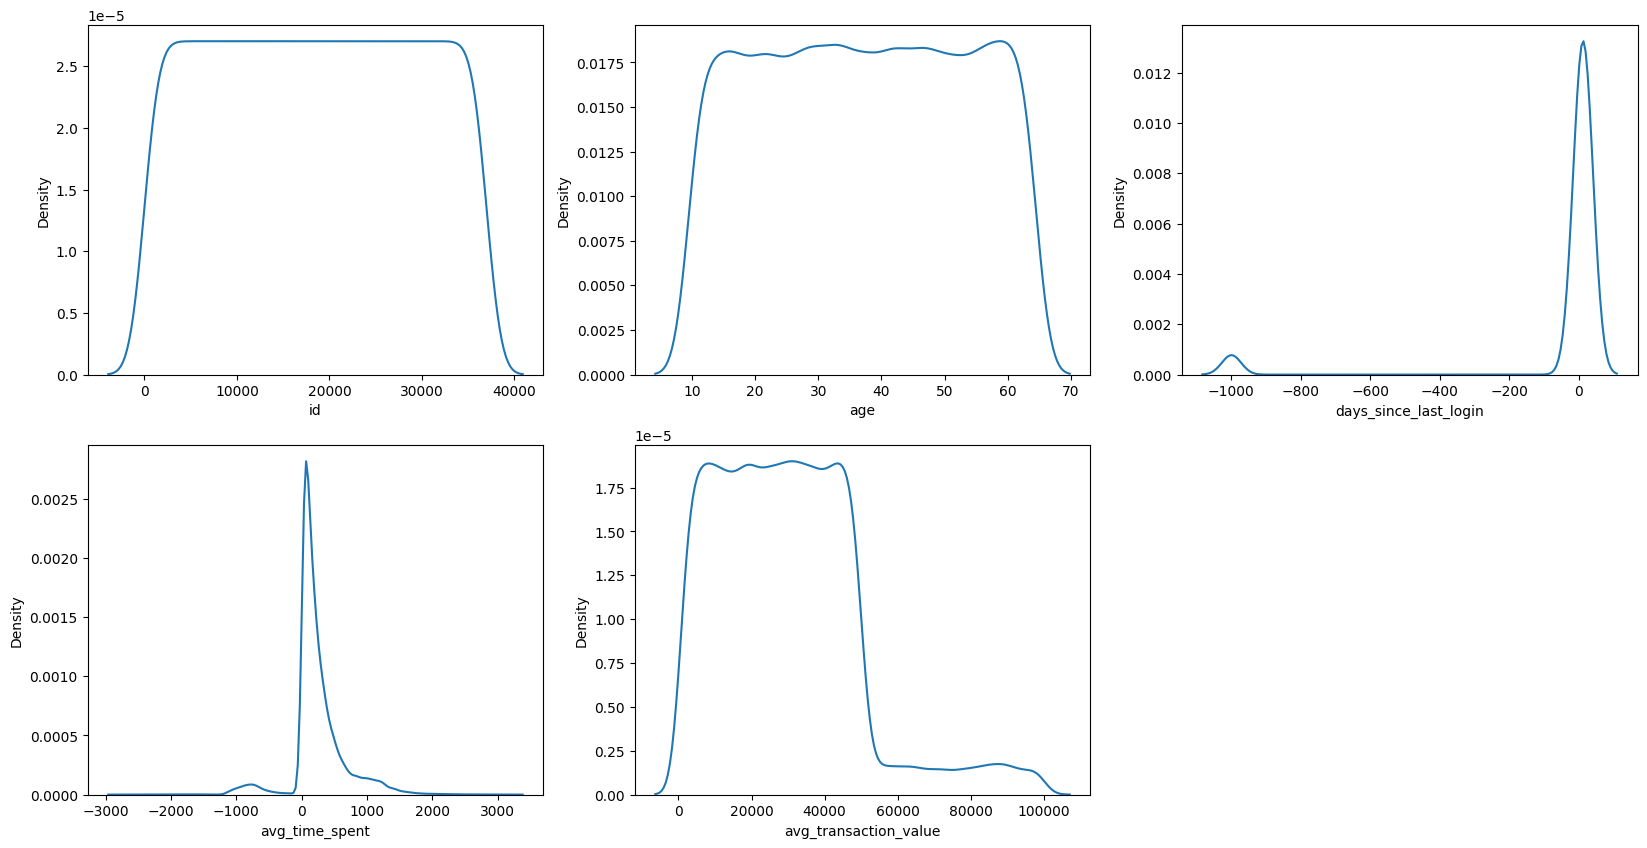

In [ ]:
data_num=merged_df.drop('churn_risk_score', axis=1).select_dtypes(include=[np.number]) 
fig,ax= plt.subplots(nrows=2,ncols=3,figsize=(20,10)) 
for variable, subplot in zip(data_num.columns,ax.flatten()):
    z = sns.kdeplot(x = data_num[variable] , ax=subplot) 
    z.set_xlabel(variable, fontsize = 10)

fig.delaxes(ax[1][2])
plt.show()

In [ ]:
data_num.skew()

id                       0.000000
age                     -0.007330
days_since_last_login   -3.941293
avg_time_spent           0.539589
avg_transaction_value    1.011053
points_in_wallet        -0.080293
dtype: float64

1. As we can see from plot independent feature `days_since_last_login` is highly left skewed
2. Features such as `age` and  `points_in_wallet` are moderately left skewed

In [ ]:
#data_cat = merged_df.drop(['referral_id','last_visit_time','avg_frequency_login_days','security_no','joining_date'], axis=1).select_dtypes(include='object')
#fig,ax= plt.subplots(nrows=4,ncols=3,figsize=(20, 25)) 
#for variable, subplot in zip(data_cat.columns,ax.flatten()):
#    z = sns.countplot(x = data_cat[variable],ax=subplot, ) 
#    z.set_xlabel(variable, fontsize = 20)
#    z.set_xticklabels(z.get_xticklabels(),rotation=45)
#    for p in z.patches:
#      z.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
#           xytext = (0, 6), textcoords = 'offset points')
    
#plt.tight_layout()


#1. As we can see both genders, `Male` and `Female` are equally distributed and there is some noise which will be handled in [Section 6.1.2](#NS_Missing_Values)
#2. Most of the customers are from town region while least number of customer belongs to village whcih is ~4600. 
#3. No & Basic category are leading one in `membership_category` while premium & platinum are least subscribed which is around ~4300+ 
#4. Around 15K customers have joined through referral program
#5. Most of the customers either use Desktop or Smartphone to access website
#6. Most of the customers has given negative feedback about the service such as `poor website`, `poor customer service` etc.

### 5.5.2 Data Distribution of Target <a id='dist_target'></a>

In [ ]:
#plt.rcParams['figure.figsize'] = [10,10] 
#ax = sns.countplot(merged_df['churn_risk_score'])
#for p in ax.patches:
#    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2. , p.get_height()), ha = 'center',
#           xytext = (0, 15), textcoords = 'offset points')
#plt.show() 

# Target feature **churn_risk_score**'s classes `Custimer will Exit (1)` and `Customer wont exit (0)` are kind of equally distributed by 5:4 ratio. 

# 6.0 Data Preprocessing <a id='data_pre'></a>

## 6.1 Missing values <a id='Missing_Values'></a>

### 6.1.1 Standard Missing Values  <a id='S_Missing_Values'></a>

In [ ]:
missing_values = pd.DataFrame({
    'missing_values':merged_df.isnull().sum(),
    'percentage': merged_df.isnull().sum()*100/merged_df.shape[0]
})

missing_values.sort_values(by='missing_values', ascending=False)

,missing_values,percentage
region_category,5428,14.673840
points_in_wallet,3443,9.307669
preferred_offer_types,288,0.778568
id,0,0.000000
security_no,0,0.000000
membership_category,0,0.000000
gender,0,0.000000
age,0,0.000000
joined_through_referral,0,0.000000
joining_date,0,0.000000


Above datafram shows that missing values which are `NaN` values but there are some non-standard missing values which needs to be treated before further processing.

### 6.1.2 Non-Standard Missing Values <a id='NS_Missing_Values'></a>

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
The non-standard missing values are replaced with NaN                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df.joined_through_referral.value_counts()

joined_through_referral
No     15838
Yes    15715
?       5438
Name: count, dtype: int64

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                      The feature joined_through_referral has unindentified '?' values which are replaced with Nan.
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['joined_through_referral'] = merged_df['joined_through_referral'].replace('?',np.nan)

In [ ]:
merged_df.gender.value_counts()

gender
F          18490
M          18442
Unknown       59
Name: count, dtype: int64

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature gender has unindentified 'Unknown' values which are replaced with Nan. 
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['gender'] = merged_df['gender'].replace('Unknown',np.nan)

In [ ]:
merged_df.referral_id.unique()

array(['xxxxxxxx', 'CID21329', 'CID12313', ..., 'CID60808', 'CID10431',
       'CID45477'], shape=(11359,), dtype=object)

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature referral_id has unindentified 'xxxxxxxx' values which are replaced with Nan.
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['referral_id'] = merged_df['referral_id'].replace('xxxxxxxx',np.nan)  

In [ ]:
merged_df.medium_of_operation.value_counts()

medium_of_operation
Desktop       13912
Smartphone    13876
?              5393
Both           3810
Name: count, dtype: int64

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>    
The feature medium_of_operation has unindentified '?' values which are replaced with Nan. 
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['medium_of_operation'] = merged_df['medium_of_operation'].replace('?',np.nan)  

In [ ]:
merged_df.days_since_last_login.value_counts()

days_since_last_login
 12     2380
 13     2373
 14     2307
 15     2277
 11     2262
 10     2091
 16     2068
-999    1999
 9      1863
 17     1747
 8      1571
 18     1444
 7      1442
 19     1308
 6      1257
 5      1234
 20     1184
 21     1015
 4       998
 22      895
 3       852
 23      727
 2       613
 24      471
 1       328
 25      203
 26       82
Name: count, dtype: int64

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature days_since_last_login has unindentified '-999' values which are replaced with Nan. 
                   </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['days_since_last_login'] = merged_df['days_since_last_login'].replace(-999,np.nan)  

In [ ]:
len(merged_df[merged_df.avg_time_spent < 0]['avg_time_spent'])

1719

In [ ]:
merged_df['avg_time_spent'] = merged_df['avg_time_spent'].apply(lambda x:x if x>=0 else np.nan)

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature avg_time_spent has negative values which are replaced with Nan
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
len(merged_df[merged_df.points_in_wallet < 0]['points_in_wallet'])

136

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature points_in_wallet has negative values which are replaced with Nan
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['points_in_wallet'] = merged_df['points_in_wallet'].apply(lambda x:x if x>=0 else np.nan)

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature avg_frequency_login_days has negative values as well as unidentified 'Error' values which are replaced with Nan
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['avg_frequency_login_days'] = merged_df['avg_frequency_login_days'].apply(lambda x:x if x!='Error' else -1)
merged_df['avg_frequency_login_days'] = merged_df['avg_frequency_login_days'].astype('float')
merged_df['avg_frequency_login_days'] = merged_df['avg_frequency_login_days'].apply(lambda x:x if x>=0 else np.nan)

In [ ]:
missing_values = pd.DataFrame({
    'missing_values': merged_df.isnull().sum(),
    'percentage': merged_df.isnull().sum()*100/merged_df.shape[0]
})

missing_values.sort_values(by='missing_values', ascending=False)

,missing_values,percentage
referral_id,17845,48.241464
joined_through_referral,5438,14.700873
region_category,5428,14.673840
medium_of_operation,5393,14.579222
avg_frequency_login_days,4204,11.364927
points_in_wallet,3579,9.675326
days_since_last_login,1999,5.404017
avg_time_spent,1719,4.647076
preferred_offer_types,288,0.778568
gender,59,0.159498


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        There are 10 features that has missing values. referral_id has the most missing values around 48%. 
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

### 6.1.3 Missing values imputation <a id='impute'></a>

**Missing values treatment for categorical variable**

In [ ]:
Missing_cat = merged_df[['gender','preferred_offer_types',
                         'region_category','joined_through_referral',
                         'medium_of_operation']]
for i,col in enumerate(Missing_cat):
    merged_df[col].fillna(merged_df[col].mode()[0], inplace=True)

**Missing values treatment for numerical variable**

In [ ]:
Missing_num = merged_df[['points_in_wallet','avg_time_spent',
                'days_since_last_login','avg_frequency_login_days']]

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed_value=imputer.fit_transform(Missing_num)

1. For imputing missing values for categorical features we have used mode value
2. For imputing missing values for numerical featurers we have used `KNNimputer` after experimenting with other imputation methods such as `mean` & `median` and we got better results with KNNimputer.

In [ ]:
d1 = pd.DataFrame({
    'avg_frequency_login_days':imputed_value.T[0],
    'points_in_wallet':imputed_value.T[1],
    'days_since_last_login':imputed_value.T[2],
    'avg_time_spent':imputed_value.T[3]

})

# not dropping id here because we will need it as the unique identifier to merge the textual data with the structured data
merged_df.drop(['avg_frequency_login_days','points_in_wallet','days_since_last_login','avg_time_spent'], axis=1, inplace=True)

merged_df2 = pd.concat([merged_df, d1], axis=1)

## 6.2 Handle Duplicate Data

In [ ]:
merged_df2[merged_df2.duplicated()]

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,used_special_discount,offer_application_preference,past_complaint,complaint_status,churn_risk_score,feedback,avg_frequency_login_days,points_in_wallet,days_since_last_login,avg_time_spent


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
There is no duplication in dataset.                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>



## 6.3 Feature Engineering  <a id='feature_eng'></a>

In [ ]:
merged_df2.joining_date

0         17/8/2017
1         28/8/2017
2        11/11/2016
3        29/10/2016
4         12/9/2017
            ...    
36986      7/9/2015
36987     21/9/2017
36988     27/6/2016
36989     11/9/2016
36990     15/6/2017
Name: joining_date, Length: 36991, dtype: object

In [ ]:
# Convert joining_date to datetime format
merged_df2['joining_date'] = pd.to_datetime(merged_df2['joining_date'], dayfirst=True, errors='coerce')

# Now extract the year difference
merged_df2['year'] = 2021 - merged_df2['joining_date'].dt.year

In [ ]:
merged_df2.drop(['security_no','joining_date','referral_id',
           'last_visit_time'], axis=1, inplace=True)

1. Created new feature `year` from joining_date 
2. Dropped features such as security_no, referral_id etc. because either they aren't valuable for predicting churn or having major missing values.

## 6.4 Outliers <a id='out'></a>

### 6.4.1 Discovery of Outliers <a id='dis_out'></a>

In [ ]:
df_num = merged_df2.select_dtypes(include=[np.number]) 

In [ ]:
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75) 
IQR = Q3 - Q1 

outlier = pd.DataFrame((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR)))
for i in outlier.columns:
    print(f'Total number of Outliers in column {i} are {len(outlier[outlier[i] == True][i])}')

Total number of Outliers in column id are 0
Total number of Outliers in column age are 0
Total number of Outliers in column avg_transaction_value are 1131
Total number of Outliers in column churn_risk_score are 0
Total number of Outliers in column avg_frequency_login_days are 4393
Total number of Outliers in column points_in_wallet are 2959
Total number of Outliers in column days_since_last_login are 0
Total number of Outliers in column avg_time_spent are 417
Total number of Outliers in column year are 0


### 6.4.2 Visualizing outliers using Boxplots <a id='viz'></a>

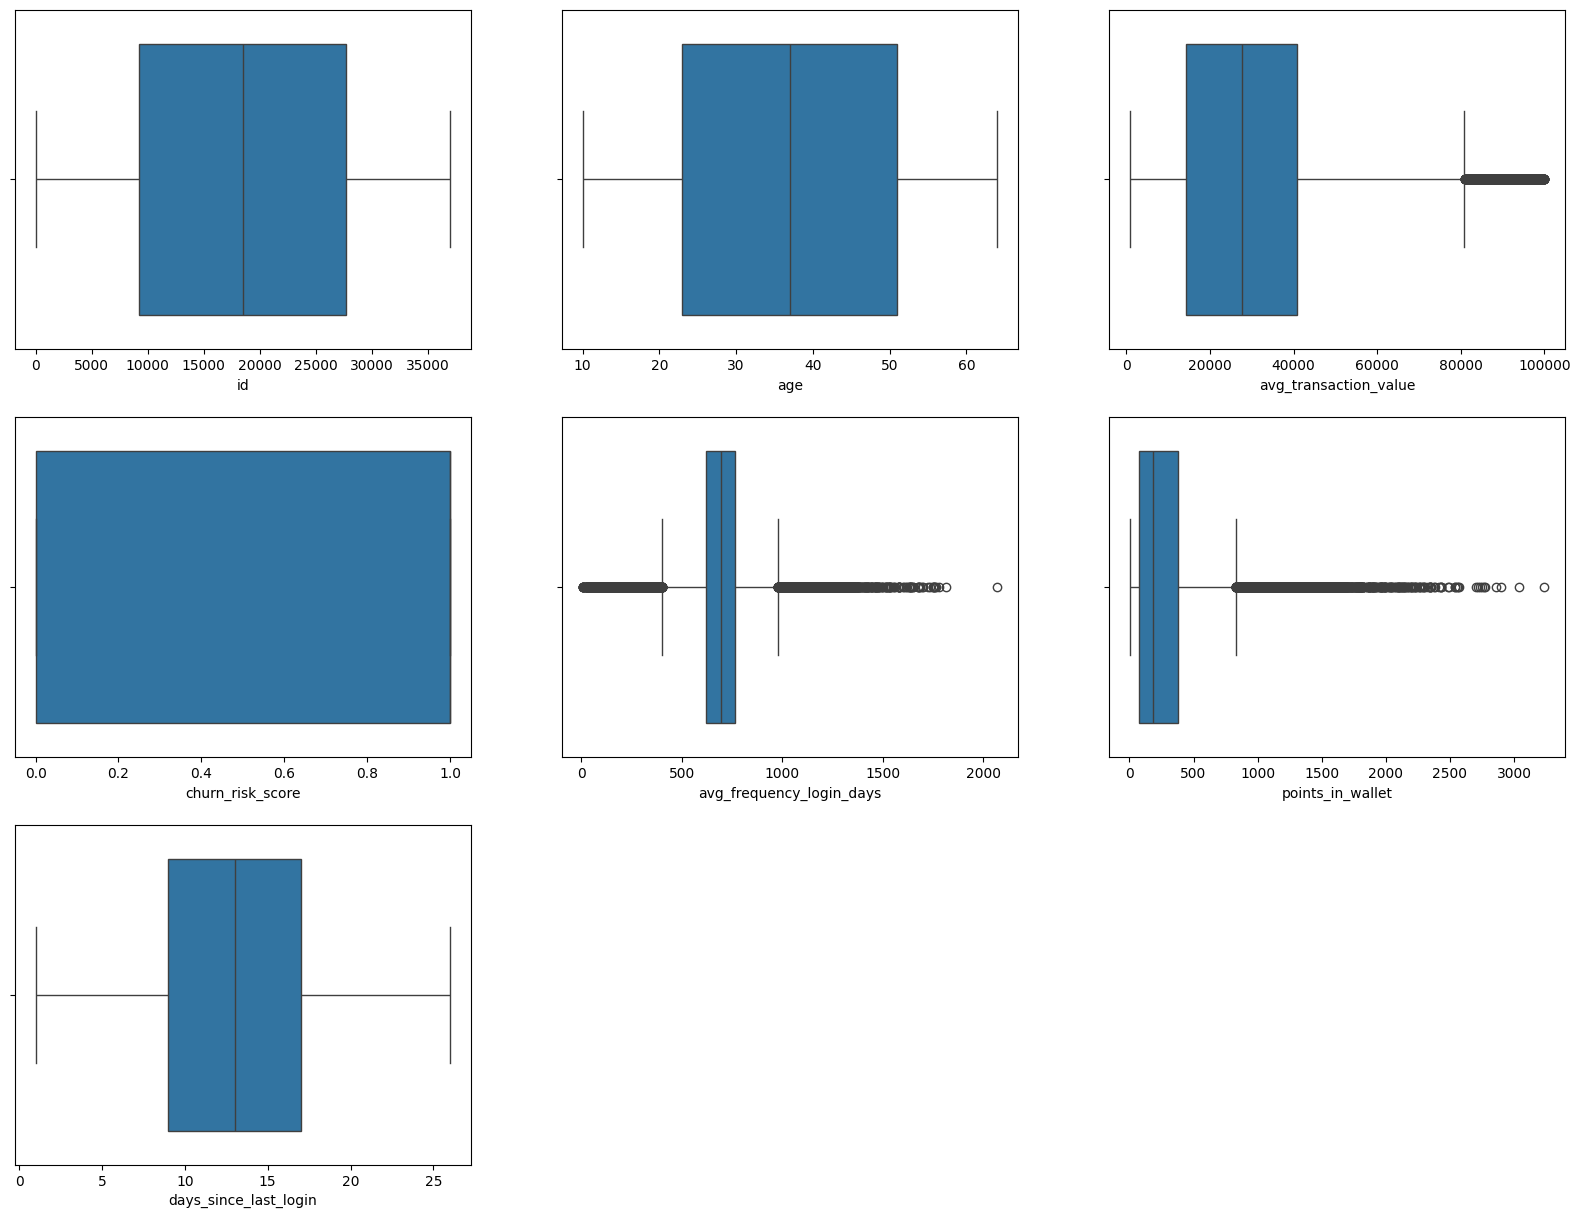

In [ ]:
fig,ax= plt.subplots(nrows=3,ncols=3,figsize=(20, 15)) 
for variable, subplot in zip(df_num.columns,ax.flatten()):
    z = sns.boxplot(x = df_num[variable], orient = "h",whis=1.5 , ax=subplot) 
    z.set_xlabel(variable, fontsize = 10)
    
fig.delaxes(ax[2][1])
fig.delaxes(ax[2][2])
plt.show()

1. Features such as `age`, `day_since_last_login` have no outliers
2. `points in wallet` and `avg frequency login days` are having outliers in large numbers, which will be treated in next section

## 6.4 Categorical Data Encoding  <a id='cat_enc'></a>

In [ ]:
df_cat = merged_df2[['gender','region_category','joined_through_referral','preferred_offer_types',
                     'medium_of_operation','internet_option','used_special_discount',
                     'offer_application_preference','past_complaint']]
df_num = merged_df2.select_dtypes(include=np.number)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler 

orderencoding_membership_category = OrdinalEncoder(categories = [["No Membership", "Basic Membership", "Silver Membership", "Gold Membership","Platinum Membership","Premium Membership"]])
merged_df2['membership_category'] = orderencoding_membership_category.fit_transform(merged_df2['membership_category'].values.reshape(-1,1))

orderencoding_complaint_status = OrdinalEncoder(categories = [["No Information Available", "Not Applicable", "Unsolved","Solved","Solved in Follow-up"]])
merged_df2['complaint_status'] = orderencoding_complaint_status.fit_transform(merged_df2['complaint_status'].values.reshape(-1,1)) 

df_categorical = pd.get_dummies(df_cat, drop_first=True, dtype=int)

1. For features such as `membership_category` and `complaint_status` we have used **OrdinalEncoder** because there is kind hierarchy in which we can order classes of these features.
2. We have used dummy encoded features such as age, region, medium_of_operation, and internet_option etc.

In [ ]:
merged_df_final = pd.concat([df_categorical, df_num, 
                             merged_df2['membership_category'], 
                             merged_df2['complaint_status'], 
                             merged_df2['feedback']], axis=1)

## 6.6 Feature Scaling  <a id='fea_sca'></a>

In [ ]:
col = merged_df_final[['age','days_since_last_login',
                       'avg_time_spent','avg_transaction_value',
                       'avg_frequency_login_days','points_in_wallet']]

merged_df_final.drop(['age','days_since_last_login','avg_time_spent',
                      'avg_transaction_value','avg_frequency_login_days',
                      'points_in_wallet'], axis=1, inplace=True)

In [ ]:
standard_scale = StandardScaler() 
col1 = standard_scale.fit_transform(col) 
merged_df_scaled = pd.DataFrame(col1, columns=col.columns)

In [ ]:
merged_df_scaled.head()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet
0,-1.204873,0.774611,0.053470,1.220580,0.508733,0.017299
1,-0.322562,0.591736,-0.812458,-0.845160,0.373800,0.034719
2,0.433705,0.225985,0.671990,-0.424028,-1.051506,0.674818
3,-0.007450,-0.322641,-1.307274,-0.207380,-0.679738,-0.737324
4,-0.385584,1.323237,-0.070234,-0.246256,-0.150147,-0.554709


In [ ]:
merged_data_final = pd.concat([merged_df_final, 
                            merged_df_scaled], axis=1 )

In [ ]:
merged_data_final.head()

,gender_M,region_category_Town,region_category_Village,joined_through_referral_Yes,preferred_offer_types_Gift Vouchers/Coupons,preferred_offer_types_Without Offers,medium_of_operation_Desktop,medium_of_operation_Smartphone,internet_option_Mobile_Data,internet_option_Wi-Fi,...,year,membership_category,complaint_status,feedback,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet
0,0,0,1,0,1,0,1,0,0,1,...,4,4.0,1.0,I’ve always appreciated the quality of custome...,-1.204873,0.774611,0.053470,1.220580,0.508733,0.017299
1,0,0,0,0,1,0,1,0,1,0,...,4,5.0,3.0,I’ve been a regular user of your website for a...,-0.322562,0.591736,-0.812458,-0.845160,0.373800,0.034719
2,0,1,0,1,1,0,1,0,0,1,...,5,0.0,4.0,I've been frustrated with the website's perfor...,0.433705,0.225985,0.671990,-0.424028,-1.051506,0.674818
3,1,0,0,1,1,0,1,0,1,0,...,5,0.0,2.0,I’ve been a regular user of your website for a...,-0.007450,-0.322641,-1.307274,-0.207380,-0.679738,-0.737324
4,0,0,0,0,0,0,0,1,1,0,...,4,0.0,3.0,No reason specified,-0.385584,1.323237,-0.070234,-0.246256,-0.150147,-0.554709


In [ ]:
# output the cleaned data
merged_data_final.to_csv("../../data/processed/cleaned_data.csv.gz", compression="gzip", index=False)

# 7.0 Preparation for Modeling <a id='eval'></a> 

In [ ]:
X = merged_data_final.drop(['churn_risk_score'] ,axis = 1)
y = merged_data_final['churn_risk_score']

## 7.1 Train test validation split with stratified sampling

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
                    X, y, train_size=0.6, 
                    stratify= y,
                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(
                    X_temp, y_temp, train_size=0.5,
                    stratify=y_temp,
                    random_state=42)


In [ ]:
# Export train and test dataset to `data` folder
pd.concat([X_train, y_train], axis=1).to_csv("../../data/input/train.csv.gz", index=False)
pd.concat([X_valid, y_valid], axis=1).to_csv("../../data/input/valid.csv.gz", index=False)
pd.concat([X_test, y_test], axis=1).to_csv("../../data/input/test.csv.gz", index=False)

## 7.2 Text Representation with LLM embedding

### 7.2.1 Generate LLM embedding for synthentic 'feedback' column

In [ ]:
import os
import pandas as pd 
from utils.prepare_llm_embedding import generate_embeddings_from_series 

EMBEDDING_TRAIN = "../../data/processed/llm_embedding_train.csv.gz"
if os.path.exists(EMBEDDING_TRAIN):
    pass
else:
    processed_text_series = pd.Series(X_train["feedback"].to_list(),
                                    index=X_train['id'].to_list()) 
    llm_embedding_train = generate_embeddings_from_series(processed_text_series,
                            additional_data={"churn_risk_score": y_train.to_list()},
                            output_csv_path="../../data/processed/llm_embedding_train.csv.gz",
                            max_workers=20)
    print(llm_embedding_train)
    

In [ ]:
import os
import pandas as pd 
from utils.prepare_llm_embedding import generate_embeddings_from_series 

EMBEDDING_VALID = "../../data/processed/llm_embedding_valid.csv.gz"
if os.path.exists(EMBEDDING_VALID):
    pass
else:
    processed_text_series = pd.Series(X_valid["feedback"].to_list(),
                                    index=X_valid['id'].to_list()) 
    llm_embedding_valid = generate_embeddings_from_series(processed_text_series,
                            additional_data={"churn_risk_score": y_valid.to_list()},
                            output_csv_path="../../data/processed/llm_embedding_valid.csv.gz",
                            max_workers=20)
    print(llm_embedding_valid)

In [ ]:
import os
import pandas as pd 
from utils.prepare_llm_embedding import generate_embeddings_from_series 

EMBEDDING_TEST = "../../data/processed/llm_embedding_test.csv.gz"
if os.path.exists(EMBEDDING_TEST):
    pass
else:
    processed_text_series = pd.Series(X_test["feedback"].to_list(),
                                    index=X_test['id'].to_list()) 
    llm_embedding_test= generate_embeddings_from_series(processed_text_series,
                            additional_data={"churn_risk_score": y_test.to_list()},
                            output_csv_path="../../data/processed/llm_embedding_test.csv.gz",
                            max_workers=20)
    print(llm_embedding_test)

### 7.2.2 Combine LLM embeddings with structured data

In [ ]:
train_text_vectorized = pd.read_csv("../../data/processed/llm_embedding_train.csv.gz", compression="gzip")
valid_text_vectorized = pd.read_csv("../../data/processed/llm_embedding_valid.csv.gz", compression="gzip")
test_text_vectorized = pd.read_csv("../../data/processed/llm_embedding_test.csv.gz", compression="gzip")

In [ ]:
import ast

# 1) Create train df which combines both structured data and textual data
train_df = pd.merge(X_train, train_text_vectorized[['id', 'embedding_json', 'churn_risk_score']], on='id', how='outer')

## Convert the list of embeddings to a DataFrame
train_df['embedding_json'] = train_df['embedding_json'].apply(ast.literal_eval)
embedding_train_df = pd.DataFrame(train_df['embedding_json'].tolist())
## Rename columns to text_feature_1, text_feature_2, ...
embedding_train_df.columns = [f"text_feature_{i+1}" for i in range(embedding_train_df.shape[1])]

## Concatenate with original dataframe (drop embedding_json)
final_train_df = pd.concat([train_df.drop(columns=['feedback', 'embedding_json']), embedding_train_df], axis=1)
final_train_df.head(3)

,gender_M,region_category_Town,region_category_Village,joined_through_referral_Yes,preferred_offer_types_Gift Vouchers/Coupons,preferred_offer_types_Without Offers,medium_of_operation_Desktop,medium_of_operation_Smartphone,internet_option_Mobile_Data,internet_option_Wi-Fi,...,text_feature_759,text_feature_760,text_feature_761,text_feature_762,text_feature_763,text_feature_764,text_feature_765,text_feature_766,text_feature_767,text_feature_768
0,0,0,1,0,1,0,1,0,0,1,...,-0.000677,0.001844,-0.086803,0.058928,-0.027327,-0.018824,-0.069696,0.032156,0.014354,0.026339
1,0,1,0,1,1,0,1,0,0,1,...,0.039687,0.011204,-0.072196,0.077847,-0.005133,0.041075,-0.045368,0.033870,0.019258,0.014128
2,0,0,0,0,0,0,0,1,1,0,...,0.004409,0.047586,-0.024953,0.044948,-0.010869,0.039905,-0.010773,-0.005092,0.035990,-0.046951


In [ ]:
# 2) Create validation df which combines both structured data and textual data
valid_df = pd.merge(X_valid, valid_text_vectorized[['id', 'embedding_json', 'churn_risk_score']], on='id', how='outer')

## Convert the list of embeddings to a DataFrame
valid_df['embedding_json'] = valid_df['embedding_json'].apply(ast.literal_eval)
embedding_valid_df = pd.DataFrame(valid_df['embedding_json'].tolist())
## Rename columns to text_feature_1, text_feature_2, ...
embedding_valid_df.columns = [f"text_feature_{i+1}" for i in range(embedding_valid_df.shape[1])]

## Concatenate with original dataframe (drop embedding_json)
final_valid_df = pd.concat([valid_df.drop(columns=['feedback', 'embedding_json']), embedding_valid_df], axis=1)
final_valid_df.head(3)

,gender_M,region_category_Town,region_category_Village,joined_through_referral_Yes,preferred_offer_types_Gift Vouchers/Coupons,preferred_offer_types_Without Offers,medium_of_operation_Desktop,medium_of_operation_Smartphone,internet_option_Mobile_Data,internet_option_Wi-Fi,...,text_feature_759,text_feature_760,text_feature_761,text_feature_762,text_feature_763,text_feature_764,text_feature_765,text_feature_766,text_feature_767,text_feature_768
0,1,0,0,1,1,0,1,0,1,0,...,0.022338,0.020910,-0.100920,0.052683,0.015286,0.029355,-0.030771,-0.013942,0.048902,0.015590
1,1,1,0,0,0,0,0,0,0,0,...,-0.005202,0.018982,-0.066354,-0.008519,-0.027693,0.017234,-0.045681,0.052762,-0.001591,0.024648
2,1,0,0,0,1,0,0,1,0,1,...,0.007548,-0.039054,-0.071410,0.049899,-0.018567,0.031301,-0.053521,0.027606,-0.016343,0.025237


In [ ]:
# 3) Create test df which combines both structured data and textual data
test_df = pd.merge(X_test, test_text_vectorized[['id', 'embedding_json', 'churn_risk_score']], on='id', how='outer')

## Convert the list of embeddings to a DataFrame
test_df['embedding_json'] = test_df['embedding_json'].apply(ast.literal_eval)
embedding_test_df = pd.DataFrame(test_df['embedding_json'].tolist())
## Rename columns to text_feature_1, text_feature_2, ...
embedding_test_df.columns = [f"text_feature_{i+1}" for i in range(embedding_test_df.shape[1])]

## Concatenate with original dataframe (drop embedding_json)
final_test_df = pd.concat([test_df.drop(columns=['feedback', 'embedding_json']), embedding_test_df], axis=1)
final_test_df.head(3)

,gender_M,region_category_Town,region_category_Village,joined_through_referral_Yes,preferred_offer_types_Gift Vouchers/Coupons,preferred_offer_types_Without Offers,medium_of_operation_Desktop,medium_of_operation_Smartphone,internet_option_Mobile_Data,internet_option_Wi-Fi,...,text_feature_759,text_feature_760,text_feature_761,text_feature_762,text_feature_763,text_feature_764,text_feature_765,text_feature_766,text_feature_767,text_feature_768
0,0,0,0,0,1,0,1,0,1,0,...,0.017961,0.053403,-0.081961,0.029364,-0.000483,0.053317,-0.030170,-0.000924,0.039492,-0.010877
1,1,0,0,0,1,0,1,0,0,1,...,0.004409,0.047586,-0.024953,0.044948,-0.010869,0.039905,-0.010773,-0.005092,0.035990,-0.046951
2,0,1,0,0,1,0,1,0,1,0,...,0.004409,0.047586,-0.024953,0.044948,-0.010869,0.039905,-0.010773,-0.005092,0.035990,-0.046951


In [ ]:
# combined X_train, X_valid, and y_test with textual data
X_train_vectorized = final_train_df.drop(columns=['id', 'churn_risk_score'])
y_train = final_train_df['churn_risk_score']

X_valid_vectorized = final_valid_df.drop(columns=['id', 'churn_risk_score'])
y_valid = final_valid_df['churn_risk_score']

X_test_vectorized = final_test_df.drop(columns=['id', 'churn_risk_score'])
y_test = final_test_df['churn_risk_score']

# 8.0 Modeling

## 8.1 Modeling on structured data

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
X_train_structured = X_train.drop(columns=['feedback'])
X_valid_structured = X_valid.drop(columns=['feedback'])
X_test_structured = X_test.drop(columns=['feedback'])

lr_model.fit(X_train_structured, y_train)

# Predictions on training and valid sets
y_train_pred_lr = lr_model.predict(X_train_structured)
y_valid_pred_lr = lr_model.predict(X_valid_structured)
y_test_pred_lr = lr_model.predict(X_test_structured)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_lr)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_lr)
test_accuracy = accuracy_score(y_test, y_test_pred_lr)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_lr, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_lr, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_lr, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_lr, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_lr, average='weighted')
test_precision = precision_score(y_test, y_test_pred_lr, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_lr, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_lr, average='weighted')
test_recall = recall_score(y_test, y_test_pred_lr, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Validation F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Validation Precision:  {valid_precision:.4f}")
print(f"Test F1-score:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Validation Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_lr))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_lr))

Train Accuracy: 0.5412
Validation Accuracy:  0.5411
Test Accuracy:  0.5403

Train F1-score: 0.3849
Validation F1-score:  0.3844
Test F1-score:  0.3824

Train Precision: 0.5320
Validation Precision:  0.5285
Test F1-score:  0.4825

Train Recall: 0.5412
Validation Recall:  0.5411
Test Recall:  0.5403

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.41      0.00      0.01      3396
           1       0.54      1.00      0.70      4003

    accuracy                           0.54      7399
   macro avg       0.48      0.50      0.35      7399
weighted avg       0.48      0.54      0.38      7399

Confusion Matrix (Test):
[[  12 3384]
 [  17 3986]]


(ii) Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Decision Tree
dt_model = DecisionTreeClassifier(max_depth=100, 
                                  min_samples_split=10, 
                                  criterion='entropy', 
                                  min_samples_leaf=100,
                                  random_state=42)

X_train_structured = X_train.drop(columns=['feedback'])
X_valid_structured = X_valid.drop(columns=['feedback'])
X_test_structured = X_test.drop(columns=['feedback'])

# Train the model
dt_model.fit(X_train_structured, y_train)

# Predictions on training and test sets
y_train_pred_dt = dt_model.predict(X_train_structured)
y_valid_pred_dt = dt_model.predict(X_valid_structured)
y_test_pred_dt = dt_model.predict(X_test_structured)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_dt)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_dt)
test_accuracy = accuracy_score(y_test, y_test_pred_dt)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_dt, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_dt, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_dt, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_dt, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_dt, average='weighted')
test_precision = precision_score(y_test, y_test_pred_dt, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_dt, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_dt, average='weighted')
test_recall = recall_score(y_test, y_test_pred_dt, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_dt))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_dt))

Train Accuracy: 0.5957
Valid Accuracy:  0.5074
Test Accuracy:  0.5006

Train F1-score: 0.5925
Valid F1-score:  0.5032
Test F1-score:  0.4964

Train Precision: 0.5931
Valid Precision:  0.5025
Valid Precision:  0.5025

Train Recall: 0.5957
Valid Recall:  0.5074
Test Recall:  0.5006

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.45      0.39      0.42      3396
           1       0.53      0.59      0.56      4003

    accuracy                           0.50      7399
   macro avg       0.49      0.49      0.49      7399
weighted avg       0.50      0.50      0.50      7399

Confusion Matrix (Test):
[[1330 2066]
 [1629 2374]]


(iii) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Train the model
rf_model = RandomForestClassifier(max_depth=10,
                            bootstrap=False,
                            random_state=42,
                            n_jobs=-1
                            )

X_train_structured = X_train.drop(columns=['feedback'])
X_valid_structured = X_valid.drop(columns=['feedback'])
X_test_structured = X_test.drop(columns=['feedback'])

rf_model.fit(X_train_structured, y_train)

# Predictions on training and test sets
y_train_pred_rf = rf_model.predict(X_train_structured)
y_valid_pred_rf = rf_model.predict(X_valid_structured)
y_test_pred_rf = rf_model.predict(X_test_structured)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_rf)
test_accuracy = accuracy_score(y_test, y_test_pred_rf)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_rf, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_rf, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_rf, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_rf, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_rf, average='weighted')
test_precision = precision_score(y_test, y_test_pred_rf, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_rf, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_rf, average='weighted')
test_recall = recall_score(y_test, y_test_pred_rf, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_rf))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_rf))

Train Accuracy: 0.6722
Valid Accuracy:  0.5376
Test Accuracy:  0.5370

Train F1-score: 0.6196
Valid F1-score:  0.4149
Test F1-score:  0.4133

Train Precision: 0.7939
Valid Precision:  0.5067
Test Precision:  0.5029

Train Recall: 0.6722
Valid Recall:  0.5376
Test Recall:  0.5370

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.46      0.05      0.09      3396
           1       0.54      0.95      0.69      4003

    accuracy                           0.54      7399
   macro avg       0.50      0.50      0.39      7399
weighted avg       0.50      0.54      0.41      7399

Confusion Matrix (Test):
[[ 164 3232]
 [ 194 3809]]


(iv) XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                            recall_score, classification_report, confusion_matrix)

# Train the model
X_train_structured = X_train.drop(columns=['feedback'])
X_valid_structured = X_valid.drop(columns=['feedback'])
X_test_structured = X_test.drop(columns=['feedback'])

xgb_model = xgb.XGBClassifier(max_depth=10,
                            random_state=42,
                            # Introduce randomness to make training faster and reduce overfitting
                            subsample=0.8, ## Uses 80% of the data for each tree.
                            colsample_bytree=0.8, ## Uses 80% of the features for each tree.
                            # the parameters below make the model trained faster by enabling parallelism
                            n_jobs = -1)
xgb_model.fit(X_train_structured, y_train)

# Predictions on training and test sets
y_train_pred_xgb = xgb_model.predict(X_train_structured)
y_valid_pred_xgb = xgb_model.predict(X_valid_structured)
y_test_pred_xgb = xgb_model.predict(X_test_structured)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred_xgb)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_xgb, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_xgb, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_xgb, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_xgb, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_xgb, average='weighted')
test_precision = precision_score(y_test, y_test_pred_xgb, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_xgb, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_xgb, average='weighted')
test_recall = recall_score(y_test, y_test_pred_xgb, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_xgb))

Train Accuracy: 0.9987
Valid Accuracy:  0.5101
Test Accuracy:  0.5102

Train F1-score: 0.9987
Valid F1-score:  0.5073
Test F1-score:  0.5062

Train Precision: 0.9987
Valid Precision:  0.5065
Test Precision:  0.5056

Train Recall: 0.9987
Valid Recall:  0.5101
Test Recall:  0.5102

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.46      0.40      0.43      3396
           1       0.54      0.60      0.57      4003

    accuracy                           0.51      7399
   macro avg       0.50      0.50      0.50      7399
weighted avg       0.51      0.51      0.51      7399

Confusion Matrix (Test):
[[1372 2024]
 [1600 2403]]


## 8.2 Modeling on mixed data (on structured data and textual data)

(i) Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
lr_model.fit(X_train_vectorized, y_train)

# Predictions on training and valid sets
y_train_pred_lr = lr_model.predict(X_train_vectorized)
y_valid_pred_lr = lr_model.predict(X_valid_vectorized)
y_test_pred_lr = lr_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_lr)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_lr)
test_accuracy = accuracy_score(y_test, y_test_pred_lr)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_lr, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_lr, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_lr, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_lr, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_lr, average='weighted')
test_precision = precision_score(y_test, y_test_pred_lr, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_lr, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_lr, average='weighted')
test_recall = recall_score(y_test, y_test_pred_lr, average='weighted')


# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Validation F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Validation Precision:  {valid_precision:.4f}")
print(f"Test F1-score:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Validation Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_lr))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_lr))

Train Accuracy: 0.8463
Validation Accuracy:  0.8490
Test Accuracy:  0.8430

Train F1-score: 0.8462
Validation F1-score:  0.8489
Test F1-score:  0.8429

Train Precision: 0.8462
Validation Precision:  0.8489
Test F1-score:  0.8428

Train Recall: 0.8463
Validation Recall:  0.8490
Test Recall:  0.8430

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      3396
           1       0.85      0.86      0.86      4003

    accuracy                           0.84      7399
   macro avg       0.84      0.84      0.84      7399
weighted avg       0.84      0.84      0.84      7399

Confusion Matrix (Test):
[[2789  607]
 [ 555 3448]]


(ii) Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Decision Tree
dt_model = DecisionTreeClassifier(max_depth=100, 
                                  min_samples_split=10, 
                                  criterion='entropy', 
                                  min_samples_leaf=100,
                                  random_state=42)

# Train the model
dt_model.fit(X_train_vectorized, y_train)

# Predictions on training and test sets
y_train_pred_dt = dt_model.predict(X_train_vectorized)
y_valid_pred_dt = dt_model.predict(X_valid_vectorized)
y_test_pred_dt = dt_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_dt)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_dt)
test_accuracy = accuracy_score(y_test, y_test_pred_dt)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_dt, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_dt, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_dt, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_dt, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_dt, average='weighted')
test_precision = precision_score(y_test, y_test_pred_dt, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_dt, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_dt, average='weighted')
test_recall = recall_score(y_test, y_test_pred_dt, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_dt))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_dt))

Train Accuracy: 0.9341
Valid Accuracy:  0.9286
Test Accuracy:  0.9290

Train F1-score: 0.9340
Valid F1-score:  0.9286
Test F1-score:  0.9290

Train Precision: 0.9341
Valid Precision:  0.9287
Valid Precision:  0.9287

Train Recall: 0.9341
Valid Recall:  0.9286
Test Recall:  0.9290

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3396
           1       0.93      0.94      0.93      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.93      0.93      7399
weighted avg       0.93      0.93      0.93      7399

Confusion Matrix (Test):
[[3115  281]
 [ 244 3759]]


(iii) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Train the model
rf_model = RandomForestClassifier(max_depth=10,
                            bootstrap=False,
                            random_state=42,
                            n_jobs=-1
                            )
rf_model.fit(X_train_vectorized, y_train)

# Predictions on training and test sets
y_train_pred_rf = rf_model.predict(X_train_vectorized)
y_valid_pred_rf = rf_model.predict(X_valid_vectorized)
y_test_pred_rf = rf_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_rf)
test_accuracy = accuracy_score(y_test, y_test_pred_rf)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_rf, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_rf, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_rf, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_rf, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_rf, average='weighted')
test_precision = precision_score(y_test, y_test_pred_rf, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_rf, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_rf, average='weighted')
test_recall = recall_score(y_test, y_test_pred_rf, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_rf))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_rf))

Train Accuracy: 0.9241
Valid Accuracy:  0.9052
Test Accuracy:  0.9094

Train F1-score: 0.9241
Valid F1-score:  0.9050
Test F1-score:  0.9093

Train Precision: 0.9241
Valid Precision:  0.9059
Test Precision:  0.9097

Train Recall: 0.9241
Valid Recall:  0.9052
Test Recall:  0.9094

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      3396
           1       0.90      0.93      0.92      4003

    accuracy                           0.91      7399
   macro avg       0.91      0.91      0.91      7399
weighted avg       0.91      0.91      0.91      7399

Confusion Matrix (Test):
[[2992  404]
 [ 266 3737]]


(iv) XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                            recall_score, classification_report, confusion_matrix)

# Train the model
xgb_model = xgb.XGBClassifier(max_depth=10,
                            random_state=42,
                            # Introduce randomness to make training faster and reduce overfitting
                            subsample=0.8, ## Uses 80% of the data for each tree.
                            colsample_bytree=0.8, ## Uses 80% of the features for each tree.
                            # the parameters below make the model trained faster by enabling parallelism
                            n_jobs = -1)
xgb_model.fit(X_train_vectorized, y_train)

# Predictions on training and test sets
y_train_pred_xgb = xgb_model.predict(X_train_vectorized)
y_valid_pred_xgb = xgb_model.predict(X_valid_vectorized)
y_test_pred_xgb = xgb_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred_xgb)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_xgb, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_xgb, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_xgb, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_xgb, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_xgb, average='weighted')
test_precision = precision_score(y_test, y_test_pred_xgb, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_xgb, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_xgb, average='weighted')
test_recall = recall_score(y_test, y_test_pred_xgb, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_xgb))

Train Accuracy: 1.0000
Valid Accuracy:  0.9259
Test Accuracy:  0.9303

Train F1-score: 1.0000
Valid F1-score:  0.9257
Test F1-score:  0.9302

Train Precision: 1.0000
Valid Precision:  0.9266
Test Precision:  0.9305

Train Recall: 1.0000
Valid Recall:  0.9259
Test Recall:  0.9303

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      3396
           1       0.92      0.95      0.94      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.93      0.93      7399
weighted avg       0.93      0.93      0.93      7399

Confusion Matrix (Test):
[[3083  313]
 [ 203 3800]]


(v) Ensemble stacking (with bi-modal model with structured data and textual data)

In [ ]:
# Note: need to change one to text later for xgb, and another one based on randomforestclassifier

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Initialize the Ensemble Stacking model

# Train the base models
X_train_structured = X_train.drop(columns=['feedback'])
X_train_embed = embedding_train_df
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_structured, y_train)

xgb = xgb.XGBClassifier(random_state=42, njobs=-1)
xgb.fit(X_train_embed, y_train)

# Make predictions
y_train_pred_rf = rf.predict(X_train_structured)
y_train_pred_xgb = xgb.predict(X_train_embed)

X_valid_structured = X_valid.drop(columns=['feedback'])
X_valid_embed = embedding_valid_df
y_valid_pred_rf = rf.predict(X_valid_structured)
y_valid_pred_xgb = xgb.predict(X_valid_embed)

X_test_structured = X_test.drop(columns=['feedback'])
X_test_embed = embedding_test_df
y_test_pred_rf = rf.predict(X_test_structured )
y_test_pred_xgb = xgb.predict(X_test_embed)


# Combine the predictions of the base models into a single feature matrix
from sklearn.linear_model import LogisticRegression
X_train_meta = np.column_stack((y_train_pred_rf, y_train_pred_xgb))
X_valid_meta = np.column_stack((y_valid_pred_rf, y_valid_pred_xgb))
X_test_meta = np.column_stack((y_test_pred_rf, y_test_pred_xgb))

# Train the meta-model on the combined feature matrix and the target values
meta_model = LogisticRegression()
meta_model.fit(X_valid_meta, y_valid)

# Predictions on training and test sets
y_valid_pred_meta = meta_model.predict(X_valid_meta)
y_test_pred_meta = meta_model.predict(X_test_meta)

# Accuracy scores
valid_accuracy = accuracy_score(y_valid, y_valid_pred_meta)
test_accuracy = accuracy_score(y_test, y_test_pred_meta)

# F1 scores
valid_f1_score = f1_score(y_valid, y_valid_pred_meta, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_meta, average='weighted')

# Precision scores
valid_precision = precision_score(y_valid, y_valid_pred_meta, average='weighted')
test_precision = precision_score(y_test, y_test_pred_meta, average='weighted')

# Recall scores
valid_recall = recall_score(y_valid, y_valid_pred_meta, average='weighted')
test_recall = recall_score(y_test, y_test_pred_meta, average='weighted')

# Output
print(f"Valid Accuracy: {valid_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}\n")

print(f"Valid F1-score: {valid_f1_score:.4f}")
print(f"Test F1-score: {test_f1_score:.4f}\n")

print(f"Valid Precision: {valid_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}\n")

print(f"Valid Recall: {valid_recall:.4f}")
print(f"Test Recall: {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_meta))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_meta))

Valid Accuracy: 0.5410
Test Accuracy: 0.5410

Valid F1-score: 0.3798
Test F1-score: 0.3799

Valid Precision: 0.2926
Test Precision: 0.2927

Valid Recall: 0.5410
Test Recall: 0.5410

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3396
           1       0.54      1.00      0.70      4003

    accuracy                           0.54      7399
   macro avg       0.27      0.50      0.35      7399
weighted avg       0.29      0.54      0.38      7399

Confusion Matrix (Test):
[[   0 3396]
 [   0 4003]]


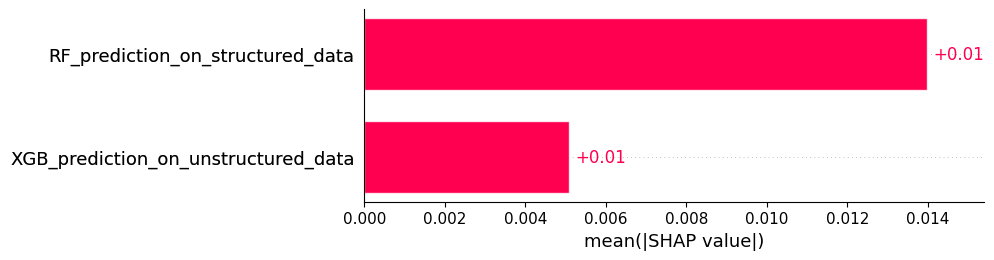

In [ ]:
# Checking either modelling on structured data or unstructured data contributes more...
import shap

feature_names = ['RF_prediction_on_structured_data', 'XGB_prediction_on_unstructured_data']

# SHAP explainer for meta-model
explainer = shap.Explainer(meta_model, X_valid_meta, feature_names=feature_names)
shap_values = explainer(X_valid_meta)

# Summary plot — shows how much each model's prediction impacts final output
shap.plots.bar(shap_values)


Both models are contributing, but Random Forest (which only uses structured data) has stronger influence on average.

The ensemble meta-model relies more on Random Forest's predictions than on XGBoost’s (which only uses textual data), for the current data.

In [ ]:
## BUG: need to delete...
#import shap

# SHAP explainer for meta-model
#explainer = shap.Explainer(rf_model, X_train_structured, 
#                    feature_names=X_train_structured.columns.tolist())
#shap_values = explainer(X_train_structured)

# Summary plot — shows how much each model's prediction impacts final output
#shap.plots.bar(shap_values)


 39%|========            | 17458/44388 [991:19<1529:09]       

# 9.0 Explainability to the modeling with LLM and SHAP analysis

After choosing a model and obtaining predictions, apply SHAP (Shapley Additive Explanations) to these predictions. SHAP helps in understanding the impact of each feature on the model's prediction for an individual sample. This step is crucial for interpreting model predictions in a human-understandable format. Discuss how SHAP values can uncover the reasoning behind a model's prediction, offering insights into which features contribute most to churn.

In [ ]:
api_key = os.getenv('OPENAI_API_KEY')

In [ ]:
import json
import shap
import pandas as pd

# Extract the LightGBM model from the pipeline
ensemble_stacking_model = final.named_steps['actual_estimator']

# Create SHAP TreeExplainer using the extracted LightGBM model
explainer = shap.TreeExplainer(ensemble_stacking_model)

# Calculate SHAP values for the test data (excluding CustomerId)
shap_values = explainer.shap_values(test_df.drop(columns=['id']))

# Convert SHAP values to DataFrame for easier manipulation
shap_df = pd.DataFrame(shap_values[1], columns=test_df.drop(columns=['id']).columns)

# Add 'CustomerId' column to shap_df for alignment
shap_df['id'] = test_df['id'].values

# Initialize a dictionary to store the JSON structures
json_structures = {}

# Generate a JSON structure for each row in shap_df
for index, row in shap_df.iterrows():
    # Create a dictionary for the current row
    row_dict = row.to_dict()

    # Use CustomerId as the key for the JSON structure and remove it from the values
    customer_id = row_dict.pop('id')
    json_structures[customer_id] = row_dict


NameError: name 'final' is not defined

In [ ]:
from langchain.llms import OpenAI
import time
import json
from langchain.document_loaders import TextLoader
from langchain.chat_models import ChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.chains import LLMChain,SequentialChain

In [ ]:
def sort_and_get_top_features(features):
    sorted_features = sorted(features.items(), key=lambda item: abs(item[1]), reverse=True)
    top_features = sorted_features[:10]
    return top_features 

# Create an empty DataFrame
features_shap_values = pd.DataFrame()

# Iterate over each ID key
for id_key, features in json_structures.items():
    sorted_features_df = sort_and_get_top_features(features)
    keys = [key for key, _ in sorted_features_df]
    values = [value for _, value in sorted_features_df]
    features_shap_values = pd.concat([features_shap_values, pd.DataFrame({"ID": id_key,
                                                                          "top10_feature": [keys],
                                                                          "top10_shap_values":[values]})])
                                     
features_shap_values = features_shap_values.reset_index(drop=True)

In [ ]:
predictions = predict_model(final, data=test, raw_score = True)

json_result = predictions.to_json(orient='records', lines=True)
parsed_json = json.loads('[' + json_result.replace('\n', ',')[:-1] + ']')

print(parsed_json[:1])

In [ ]:
def prepare_input_data(user_id, parsed_json, json_structures):
    desired_data = next(item for item in parsed_json if item['id'] == int(user_id))
    
    meta_data = {
    'CreditScore': desired_data['CreditScore'],
    'Gender': desired_data['Gender'],
    'Age': desired_data['Age'],
    'Tenure': desired_data['Tenure'],
    'Balance': desired_data['Balance'],
    'NumOfProducts': desired_data['NumOfProducts'],
    'HasCrCard': desired_data['HasCrCard'],
    'IsActiveMember': desired_data['IsActiveMember'],
    'EstimatedSalary': desired_data['EstimatedSalary']
    }
    
    result = desired_data['prediction_label']
    
    shap_values = json_structures[int(user_id)]
    
    return meta_data, result, shap_values

In [ ]:
def generate_churn_explainability(meta_data, result, shap_values):
    
    # Create Model
    llm = ChatOpenAI(openai_api_key = api_key)
    
    columns = ['CustomerId', 'CreditScore', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Geography_France', 'Geography_Germany', 'Geography_Spain',]
    
    # Get columns  for user 
    template0 = "Explain the significance and potential usage of the following data columns in a dataset: {columns}. Provide a simple description for each column."
    prompt0 = ChatPromptTemplate.from_template(template0)
    chain_0 = LLMChain(llm=llm,
                   prompt=prompt0,
                   output_key="column_descriptions")


    # Get meta data description for user 
    template1 = "Explain {meta_data} based on the information provided by {column_descriptions}."
    prompt1 = ChatPromptTemplate.from_template(template1)
    chain_1 = LLMChain(llm=llm,
                       prompt=prompt1,
                       output_key="meta_data_description")

    # Get explainability for the user 
    system_template = "You are a churn problem explainability assistant. Your goal is to understand the  complexities\
                       of customer loss and uncover why customers are leaving a service or product in business models.\
                       The explanations should be simple and understandable for users to analyze."
    system_message_prompt = SystemMessagePromptTemplate.from_template(system_template)

    human_template = "The {result} value has been obtained in a machine learning model using the \
                     {meta_data_description}. The {shap_values} represent the Shapley values for each feature,\
                     indicating why the model produced this particular result. Shapley values provide insights into\
                     the contribution of each feature to the final prediction. Explain why such a result was obtained\
                     in a way that the user can understand. Don't explain what the Shapley value is in a technical\
                     manner, using language that a non-technical person can understand. Maximum text length should\
                     be 200 words. Provide a concise explanation without using the phrase 'based on."
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)

    prompt2 = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])
    chain_2 = LLMChain(llm=llm,
                       prompt=prompt2,
                       output_key="explanation")
    
    
    template3 = "Provide strategies based on {explanation} to prevent user loss. Explain in language that a non-technical \
                 person can understand. Maximum text length should be 200 words. Provide a concise explanation without using the \
                 phrase 'based on."
    prompt3 = ChatPromptTemplate.from_template(template3)
    chain_3 = LLMChain(llm=llm,
                       prompt=prompt3,
                       output_key="recommendation")
    
    # Define the sequential chain of operations with the new chain
    seq_chain = SequentialChain(chains=[chain_0, chain_1, chain_2, chain_3],
                                input_variables=['columns', 'meta_data', 'result', 'shap_values'],
                                output_variables=['column_descriptions', 'meta_data_description', 'explanation', 'recommendation'],
                                verbose=True)

    input_data = {
        'columns': columns,  # Veri kolonları buraya eklenir
        'meta_data': meta_data,
        'result': result,
        'shap_values': shap_values
    }

    output = seq_chain(input_data)

    return output

In [ ]:
meta_datas, results, shap_valuess = prepare_input_data(15642785, parsed_json, json_structures)
churn_explainability_sample_1 = generate_churn_explainability(meta_datas, results, shap_valuess)
idx = features_shap_values.loc[features_shap_values.ID == 15642785].index
features_shap_values.loc[idx,'explanation'] = churn_explainability_sample_1['explanation']
features_shap_values.loc[idx, 'recommendation'] = churn_explainability_sample_1['recommendation']
time.sleep(60)